In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [43]:
!pip install scipy
!pip install seaborn
!pip install spacy

You should consider upgrading via the 'pip install --upgrade pip' command.


## Import packages and data

In [46]:
import filter_method
import outlier

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import spacy
from scipy import stats 

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.preprocessing import MinMaxScaler


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [48]:
path = ""

In [50]:
# X_train = pd.read_pickle("X_train.pkl")
X_test = pd.read_pickle("X_test.pkl")
# y_train = pd.read_pickle("y_train.pkl")
# y_test = pd.read_pickle("y_test.pkl")

In [15]:
# check same length of samples and labels
# train
assert X_train.shape[0] == y_train.shape[0]
# test
assert X_test.shape[0] == y_test.shape[0]

# check same features
assert X_train.shape[1] == X_test.shape[1]

## Delete irrelevant features and outliers.

In [51]:
pd.to_pickle(X_test['joke_x'], path + "X_test_just_jokes.pkl")

### Delete text features

In [16]:
del X_train['joke_x']
del X_train['joke_tokenized']
del X_train['joke_text_processed']
del X_train['joke_processed_tokenized']
del X_train['joke_processed_tokenized_stemmed']
del X_train['joke_processed_tokenized_stemmed_str']
# del X_train['joke_embbedings']
del X_test['joke_x']
del X_test['joke_tokenized']
del X_test['joke_text_processed']
del X_test['joke_processed_tokenized']
del X_test['joke_processed_tokenized_stemmed']
del X_test['joke_processed_tokenized_stemmed_str']
# del X_test['joke_embbedings']

### Outliers

#### Define functions.

In [17]:
# unlimited the outliers
def unlimited_by_quantile(y, quantile=0.95):
    """
      params: y - labels
              quantile - 0.95(default)
      return: y - after limited the outliers.
    """
    
    limit_var = y.quantile(quantile)
    y[y >  y.quantile(quantile)] = limit_var
    return y, limit_var

In [18]:
# remove the outliers
def remove_outliers_by_quantile(col, start_quantile=0.025, end_quantile=0.975):
    """
      params: col - Series
              start_quantile - 0.025(default)
              end_quantile - 0.975(default)
      return: col after remove outliers
    """
    col = col[col.between(col.quantile(start_quantile), col.quantile(end_quantile))]
    return col

In [19]:
# Remove skew
def remove_skew_95(X,y,mean = None,std = None):
    """
      params: X - dataframe_of_features.
              y - labels
              mean - the mean of y
              std - the standard deviation of y
      return: X, y - without the outliers.
    """
    if not mean:
        mean = y.mean()
    if not std:
        std = y.std()
    X = X[(y > (mean-2*std)) & (y < (mean+2*std))]
    y = y[(y > (mean-2*std)) & (y < (mean+2*std))]
    return X,y

In [20]:
# check missing values in a dataframe
def check_missing_data(df):
  """ 
      params: dataframe
      return: data of missing values, if have some.
  """
  flag=df.isna().sum().any()
  if flag==True:
      total = df.isnull().sum()
      percent = (df.isnull().sum())*100/(df.isnull().count())
      output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
      data_type = []
      for col in df.columns:
          dtype = str(df[col].dtype)
          data_type.append(dtype)
      output['Types'] = data_type
      return (output[output['Percent'] > 0].sort_values(by='Percent', ascending=False))
  else:
      return False

#### Remove outliers from the features

In [21]:
# for col in X_train.columns.to_list():
#     X_train[col] = remove_outliers_by_quantile(X_train[col])

#### Remove outliers from target variable - joke score.

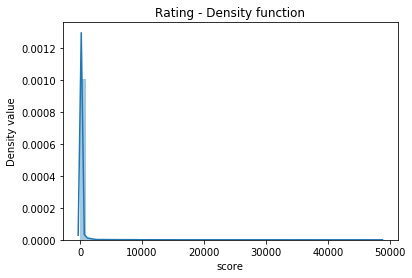

In [22]:
# plot scores with outliers.
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

In [23]:
y_train, _ = unlimited_by_quantile(y_train, 0.98)

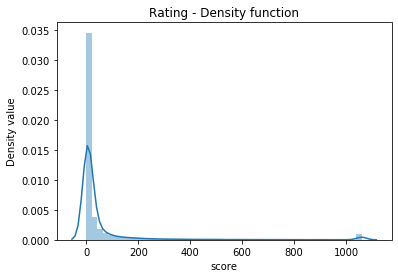

In [24]:
# plot scores without outliers.
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

## Features scaling

### Target variable - joke score

Distribution before any preprocessing

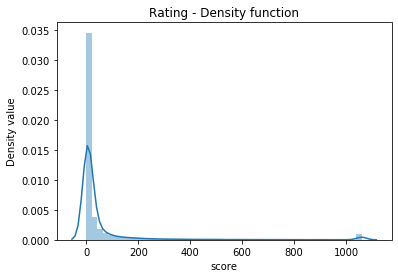

In [25]:
# Feature scaling and outliers removal
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

Use log to the target varible and scaling [0,1] -> try to create normal distribution.

In [26]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [27]:
scaler = MinMaxScaler()
scaler.fit(y_train.to_numpy().reshape(-1, 1))
y_train = pd.DataFrame(scaler.transform(y_train.to_numpy().reshape(-1, 1)))
y_test = pd.DataFrame(scaler.transform(y_test.to_numpy().reshape(-1, 1)))

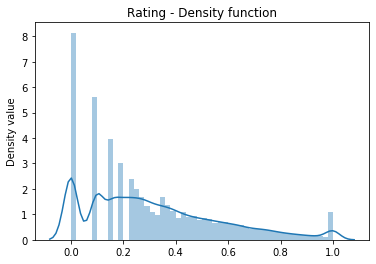

In [28]:
# Feature scaling and outliers removal
ax = sns.distplot(y_train);
ax.set_title('Rating - Density function');
ax.set_ylabel('Density value');
plt.show();

### Feature scaling

In [29]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns.to_list())
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns.to_list())

In [30]:
# verify that there is no missing values after the preprossing.
missing_X_train = check_missing_data(X_train)
missing_X_test = check_missing_data(X_test)

assert not missing_X_train
assert not missing_X_test

## Feature selection

Run Extra Tree for extract best features (without the embedding features).

In [31]:
all_features_names = X_train.columns # .str.startswith("UNIVERSAL_SENTENCE_ENCODER")
embedding_features = [f for f in all_features_names if "UNIVERSAL_SENTENCE_ENCODER" in f]
features_without_embedding = [f for f in all_features_names if f not in embedding_features]

In [32]:
select_f_model = ExtraTreesRegressor(n_estimators=2)
select_f_model.fit(X_train[features_without_embedding], y_train)
select_features = SelectFromModel(select_f_model, prefit=True) 
selected_df = select_features.transform(X_train[features_without_embedding])
num_of_features = selected_df.shape[1]

# Sort feature importances in descending order, and remain the best features by the seletion model
importances = select_f_model.feature_importances_
indices = np.argsort(importances)[::-1][:num_of_features]

# get feature names list
importance_features_names = [X_train[features_without_embedding].columns[i] for i in indices]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [33]:
pd.to_pickle(select_features, path + "select_features_model.pkl")
pd.to_pickle(features_without_embedding, path + "features_without_embedding_list.pkl")

In [34]:
selected_X_train = X_train.loc[:,importance_features_names + embedding_features]
selected_X_test = X_test.loc[:,importance_features_names + embedding_features]

assert selected_X_train.shape[1] == selected_X_test.shape[1]

In [35]:
selected_X_train.head(1)

,total_chars,MEAN_CHARACTERS_PER_WORD(joke),PUNCTUATION_COUNT(joke),POLARITY_SCORE(joke),best_score_similarity_words,STOPWORD_COUNT(joke),total_words,speical_chars,longest_word,ambiguous_words,TITLE_WORD_COUNT(joke),UPPER_CASE_COUNT(joke),ADJ,PART,SCONJ,SPACE,ADP,CCONJ,AUX,PRON,PERSON,ADV,africa,ORG,VERB,gon,DET,NORP,INTJ,funeral,DATE,state,GPE,100,making,die,wear,iphone,NUM,PROPN,rest,couple,important,using,calling,angry,CARDINAL,donald,vagina,juan,dad,mr,girlfriend,sitting,ship,helen,sent,roof,fuck,le,crack,lost,hotel,game,bee,baby,cock,america,antonyms,wondering,key,player,great,pussy,shoulder,stopped,TIME,viagra,NOUN,terrible,belt,trust,ORDINAL,rip,vegetable,small,knock,hooker,pig,SYM,potter,story,book,lawyer,jew,edit,human,bear,read,high,honey,dropped,run,asks,chick,bar bartender,wait,italian,worse,perfect,seeing,hide,ocean,X,number,college,snow,twin,fat,alcoholic,cell,old,cancer,like like,somebody,bomb,WORK_OF_ART,relationship,eat,captain,knee,color,water,pencil,shop,person,stair,deal,boat,dress,magician,sheep,news,wake,turned,sexual,black people,know,paid,sister,bacon,student,toilet paper,sir,corner,try,plane,husband,brown,young,mean,roll,early,bed,inside,vegan,nail,officer,bulb,50,instead,jewish,support,laughing,black guy,city,beat,say hey,worked,little,computer,toilet,wearing,homeless,lot like,right,middle,fight,hot,tank,minute,walking,donald trump,thinking,pilot,baseball,walk bar,soon,open,trouble,fly,line,man say,hit,worry,UNIVERSAL_SENTENCE_ENCODER(joke)[0],UNIVERSAL_SENTENCE_ENCODER(joke)[1],UNIVERSAL_SENTENCE_ENCODER(joke)[2],UNIVERSAL_SENTENCE_ENCODER(joke)[3],UNIVERSAL_SENTENCE_ENCODER(joke)[4],UNIVERSAL_SENTENCE_ENCODER(joke)[5],UNIVERSAL_SENTENCE_ENCODER(joke)[6],UNIVERSAL_SENTENCE_ENCODER(joke)[7],UNIVERSAL_SENTENCE_ENCODER(joke)[8],UNIVERSAL_SENTENCE_ENCODER(joke)[9],UNIVERSAL_SENTENCE_ENCODER(joke)[10],UNIVERSAL_SENTENCE_ENCODER(joke)[11],UNIVERSAL_SENTENCE_ENCODER(joke)[12],UNIVERSAL_SENTENCE_ENCODER(joke)[13],UNIVERSAL_SENTENCE_ENCODER(joke)[14],UNIVERSAL_SENTENCE_ENCODER(joke)[15],UNIVERSAL_SENTENCE_ENCODER(joke)[16],UNIVERSAL_SENTENCE_ENCODER(joke)[17],UNIVERSAL_SENTENCE_ENCODER(joke)[18],UNIVERSAL_SENTENCE_ENCODER(joke)[19],UNIVERSAL_SENTENCE_ENCODER(joke)[20],UNIVERSAL_SENTENCE_ENCODER(joke)[21],UNIVERSAL_SENTENCE_ENCODER(joke)[22],UNIVERSAL_SENTENCE_ENCODER(joke)[23],UNIVERSAL_SENTENCE_ENCODER(joke)[24],UNIVERSAL_SENTENCE_ENCODER(joke)[25],UNIVERSAL_SENTENCE_ENCODER(joke)[26],UNIVERSAL_SENTENCE_ENCODER(joke)[27],UNIVERSAL_SENTENCE_ENCODER(joke)[28],UNIVERSAL_SENTENCE_ENCODER(joke)[29],UNIVERSAL_SENTENCE_ENCODER(joke)[30],UNIVERSAL_SENTENCE_ENCODER(joke)[31],UNIVERSAL_SENTENCE_ENCODER(joke)[32],UNIVERSAL_SENTENCE_ENCODER(joke)[33],UNIVERSAL_SENTENCE_ENCODER(joke)[34],UNIVERSAL_SENTENCE_ENCODER(joke)[35],UNIVERSAL_SENTENCE_ENCODER(joke)[36],UNIVERSAL_SENTENCE_ENCODER(joke)[37],UNIVERSAL_SENTENCE_ENCODER(joke)[38],UNIVERSAL_SENTENCE_ENCODER(joke)[39],UNIVERSAL_SENTENCE_ENCODER(joke)[40],UNIVERSAL_SENTENCE_ENCODER(joke)[41],UNIVERSAL_SENTENCE_ENCODER(joke)[42],UNIVERSAL_SENTENCE_ENCODER(joke)[43],UNIVERSAL_SENTENCE_ENCODER(joke)[44],...,UNIVERSAL_SENTENCE_ENCODER(joke)[262],UNIVERSAL_SENTENCE_ENCODER(joke)[263],UNIVERSAL_SENTENCE_ENCODER(joke)[264],UNIVERSAL_SENTENCE_ENCODER(joke)[265],UNIVERSAL_SENTENCE_ENCODER(joke)[266],UNIVERSAL_SENTENCE_ENCODER(joke)[267],UNIVERSAL_SENTENCE_ENCODER(joke)[268],UNIVERSAL_SENTENCE_ENCODER(joke)[269],UNIVERSAL_SENTENCE_ENCODER(joke)[270],UNIVERSAL_SENTENCE_ENCODER(joke)[271],UNIVERSAL_SENTENCE_ENCODER(joke)[272],UNIVERSAL_SENTENCE_ENCODER(joke)[273],UNIVERSAL_SENTENCE_ENCODER(joke)[274],UNIVERSAL_SENTENCE_ENCODER(joke)[275],UNIVERSAL_SENTENCE_ENCODER(joke)[276],UNIVERSAL_SENTENCE_ENCODER(joke)[277],UNIVERSAL_SENTENCE_ENCODER(joke)[278],UNIVERSAL_SENTENCE_ENCODER(joke)[279],UNIVERSAL_SENTENCE_ENCODER(joke)[280],UNIVERSAL_SENTENCE_ENCODER(joke)[281],UNIVERSAL_SENTENCE_ENCODER(joke)[282],UNIVERSAL_SENTENCE_ENCODER(joke)[283],UNIVERSAL_SENTENCE_ENCODER(joke)[284],UNIVERSAL

In [36]:
pd.to_pickle(selected_X_train, path + "Selected_X_train.pkl")
pd.to_pickle(selected_X_test, path + "Selected_X_test.pkl")
pd.to_pickle(y_train, path + "Selected_y_train.pkl")
pd.to_pickle(y_test, path + "Selected_y_test.pkl")